In [19]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff


from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.compat.v1 import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

### Loading data

In [14]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

### Train set

In [15]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [16]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


### Time period of the train dataset

In [17]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


#### Let's find out what's the time gap between the last day from training set from the last day of the test set, this will be out lag (the amount of day that need to be forecast)

In [18]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


###  EDA

To explore the time series data first we need to aggregate the sales by day

In [19]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

### Overall daily sales

In [20]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

### Daily sales by store

In [21]:
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

### Daily sales by item

In [22]:
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

#### Sub-sample train set to get only the last year of data and reduce training time

In [23]:
train = train[(train['date'] >= '2017-01-01')]

### Rearrange dataset so we can apply shift methods

In [24]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,19
1,1,1,2017-01-02,15
2,1,1,2017-01-03,10
3,1,1,2017-01-04,16
4,1,1,2017-01-05,14


### Transform the data into a time series problem

In [25]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### We will use the current timestep and the last 29 to forecast 90 days ahead

In [26]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),store(t-26),sales(t-26),item(t-25),store(t-25),sales(t-25),item(t-24),store(t-24),sales(t-24),item(t-23),store(t-23),sales(t-23),item(t-22),store(t-22),sales(t-22),item(t-21),store(t-21),sales(t-21),item(t-20),store(t-20),sales(t-20),item(t-19),store(t-19),sales(t-19),item(t-18),store(t-18),sales(t-18),item(t-17),store(t-17),sales(t-17),item(t-16),...,sales(t-12),item(t-11),store(t-11),sales(t-11),item(t-10),store(t-10),sales(t-10),item(t-9),store(t-9),sales(t-9),item(t-8),store(t-8),sales(t-8),item(t-7),store(t-7),sales(t-7),item(t-6),store(t-6),sales(t-6),item(t-5),store(t-5),sales(t-5),item(t-4),store(t-4),sales(t-4),item(t-3),store(t-3),sales(t-3),item(t-2),store(t-2),sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,...,10.0,1.0,1.0,16.0,1.0,1.0,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1,1,9,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,...,16.0,1.0,1.0,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1,1,17,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,...,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1,1,15,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,1.0,15.0,1.0,...,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1,1,17,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,1.0,15.0,1.0,1.0,14.0,1.0,...,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1.0,1.0,17.0,1,1,24,1.0,1.0,19.0


#### Drop rows with different item or store values than the shifted columns

In [27]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

#### Remove unwanted columns

In [28]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

### Train/validation split

In [29]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),sales(t-19),sales(t-18),sales(t-17),sales(t-16),sales(t-15),sales(t-14),sales(t-13),sales(t-12),sales(t-11),sales(t-10),sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
18801,97.0,111.0,90.0,115.0,123.0,70.0,99.0,74.0,107.0,108.0,121.0,136.0,82.0,106.0,81.0,80.0,108.0,131.0,115.0,86.0,85.0,95.0,123.0,109.0,127.0,132.0,87.0,101.0,102.0,114
160385,38.0,43.0,43.0,55.0,47.0,51.0,38.0,41.0,37.0,59.0,37.0,36.0,48.0,35.0,42.0,40.0,43.0,54.0,56.0,64.0,41.0,38.0,38.0,53.0,53.0,45.0,44.0,24.0,30.0,37
73123,55.0,45.0,41.0,46.0,47.0,36.0,30.0,46.0,41.0,42.0,55.0,64.0,30.0,38.0,36.0,38.0,38.0,40.0,46.0,43.0,38.0,36.0,40.0,50.0,44.0,44.0,40.0,38.0,50.0,49
90428,139.0,157.0,85.0,99.0,136.0,110.0,121.0,123.0,147.0,91.0,112.0,110.0,104.0,115.0,143.0,156.0,95.0,88.0,106.0,128.0,130.0,128.0,128.0,95.0,116.0,110.0,117.0,118.0,129.0,132
167151,86.0,58.0,88.0,87.0,114.0,113.0,64.0,76.0,87.0,81.0,78.0,95.0,100.0,63.0,77.0,80.0,103.0,64.0,71.0,74.0,55.0,66.0,59.0,53.0,63.0,59.0,77.0,39.0,56.0,62


### MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [30]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [32]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)


In [33]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 7s - loss: 396.4911 - val_loss: 371.0771 - 7s/epoch - 2ms/step
Epoch 2/40
3149/3149 - 6s - loss: 363.6005 - val_loss: 362.2590 - 6s/epoch - 2ms/step
Epoch 3/40
3149/3149 - 6s - loss: 357.9643 - val_loss: 373.4828 - 6s/epoch - 2ms/step
Epoch 4/40
3149/3149 - 6s - loss: 356.4803 - val_loss: 383.9130 - 6s/epoch - 2ms/step
Epoch 5/40
3149/3149 - 6s - loss: 355.3464 - val_loss: 356.3162 - 6s/epoch - 2ms/step
Epoch 6/40
3149/3149 - 6s - loss: 353.8388 - val_loss: 352.7443 - 6s/epoch - 2ms/step
Epoch 7/40
3149/3149 - 6s - loss: 352.6495 - val_loss: 356.8575 - 6s/epoch - 2ms/step
Epoch 8/40
3149/3149 - 6s - loss: 351.5346 - val_loss: 349.5616 - 6s/epoch - 2ms/step
Epoch 9/40
3149/3149 - 6s - loss: 351.0129 - val_loss: 354.8997 - 6s/epoch - 2ms/step
Epoch 10/40
3149/3149 - 6s - loss: 349.6908 - val_loss: 350.1218 - 6s/epoch - 2ms/step
Epoch 11/40
3149/3149 - 6s - loss: 348.9591 - val_loss: 347.6833 - 6s/epoch - 2ms/step
Epoch 12/40
3149/3149 - 6s - loss: 347.3473 - val_lo

### CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [34]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [36]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
#model_cnn.summary()

In [37]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 11s - loss: 415.6956 - val_loss: 387.3594 - 11s/epoch - 3ms/step
Epoch 2/40
3149/3149 - 10s - loss: 384.3950 - val_loss: 380.7798 - 10s/epoch - 3ms/step
Epoch 3/40
3149/3149 - 10s - loss: 373.0981 - val_loss: 374.4720 - 10s/epoch - 3ms/step
Epoch 4/40
3149/3149 - 10s - loss: 368.4092 - val_loss: 381.3375 - 10s/epoch - 3ms/step
Epoch 5/40
3149/3149 - 10s - loss: 366.6580 - val_loss: 366.5718 - 10s/epoch - 3ms/step
Epoch 6/40
3149/3149 - 10s - loss: 364.7402 - val_loss: 361.7381 - 10s/epoch - 3ms/step
Epoch 7/40
3149/3149 - 10s - loss: 363.2614 - val_loss: 367.0972 - 10s/epoch - 3ms/step
Epoch 8/40
3149/3149 - 10s - loss: 362.1298 - val_loss: 358.5634 - 10s/epoch - 3ms/step
Epoch 9/40
3149/3149 - 9s - loss: 361.5669 - val_loss: 365.8694 - 9s/epoch - 3ms/step
Epoch 10/40
3149/3149 - 10s - loss: 359.9788 - val_loss: 355.8369 - 10s/epoch - 3ms/step
Epoch 11/40
3149/3149 - 10s - loss: 357.8437 - val_loss: 353.4835 - 10s/epoch - 3ms/step
Epoch 12/40
3149/3149 - 10s - lo

### LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

In [39]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
#model_lstm.summary()

In [40]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 99s - loss: 759.0278 - val_loss: 593.1250 - 99s/epoch - 31ms/step
Epoch 2/40
3149/3149 - 99s - loss: 488.9191 - val_loss: 506.1132 - 99s/epoch - 31ms/step
Epoch 3/40
3149/3149 - 96s - loss: 456.6750 - val_loss: 444.8658 - 96s/epoch - 31ms/step
Epoch 4/40
3149/3149 - 97s - loss: 416.5573 - val_loss: 409.1904 - 97s/epoch - 31ms/step
Epoch 5/40
3149/3149 - 97s - loss: 561.6001 - val_loss: 540.5861 - 97s/epoch - 31ms/step
Epoch 6/40
3149/3149 - 96s - loss: 574.7639 - val_loss: 539.6975 - 96s/epoch - 31ms/step
Epoch 7/40
3149/3149 - 96s - loss: 451.1056 - val_loss: 423.8815 - 96s/epoch - 31ms/step
Epoch 8/40
3149/3149 - 96s - loss: 455.1232 - val_loss: 560.9333 - 96s/epoch - 31ms/step
Epoch 9/40
3149/3149 - 98s - loss: 540.1225 - val_loss: 486.7147 - 98s/epoch - 31ms/step
Epoch 10/40
3149/3149 - 99s - loss: 470.4375 - val_loss: 450.7296 - 99s/epoch - 31ms/step
Epoch 11/40
3149/3149 - 96s - loss: 595.3883 - val_loss: 594.3600 - 96s/epoch - 30ms/step
Epoch 12/40
3149/31

### CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [41]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (100746, 2, 15, 1)
Validation set shape (67164, 2, 15, 1)


In [42]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [43]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 27s - loss: 440.4790 - val_loss: 419.7848 - 27s/epoch - 9ms/step
Epoch 2/40
3149/3149 - 23s - loss: 413.3398 - val_loss: 406.2218 - 23s/epoch - 7ms/step
Epoch 3/40
3149/3149 - 23s - loss: 406.3075 - val_loss: 404.4270 - 23s/epoch - 7ms/step
Epoch 4/40
3149/3149 - 23s - loss: 403.5919 - val_loss: 402.8966 - 23s/epoch - 7ms/step
Epoch 5/40
3149/3149 - 23s - loss: 402.6129 - val_loss: 412.1343 - 23s/epoch - 7ms/step
Epoch 6/40
3149/3149 - 23s - loss: 400.8914 - val_loss: 397.4154 - 23s/epoch - 7ms/step
Epoch 7/40
3149/3149 - 23s - loss: 399.5282 - val_loss: 397.9829 - 23s/epoch - 7ms/step
Epoch 8/40
3149/3149 - 23s - loss: 398.1450 - val_loss: 394.2111 - 23s/epoch - 7ms/step
Epoch 9/40
3149/3149 - 23s - loss: 396.5144 - val_loss: 396.1487 - 23s/epoch - 7ms/step
Epoch 10/40
3149/3149 - 23s - loss: 394.9737 - val_loss: 389.7186 - 23s/epoch - 7ms/step
Epoch 11/40
3149/3149 - 24s - loss: 389.1581 - val_loss: 382.6078 - 24s/epoch - 8ms/step
Epoch 12/40
3149/3149 - 23s - 

### Comparing models

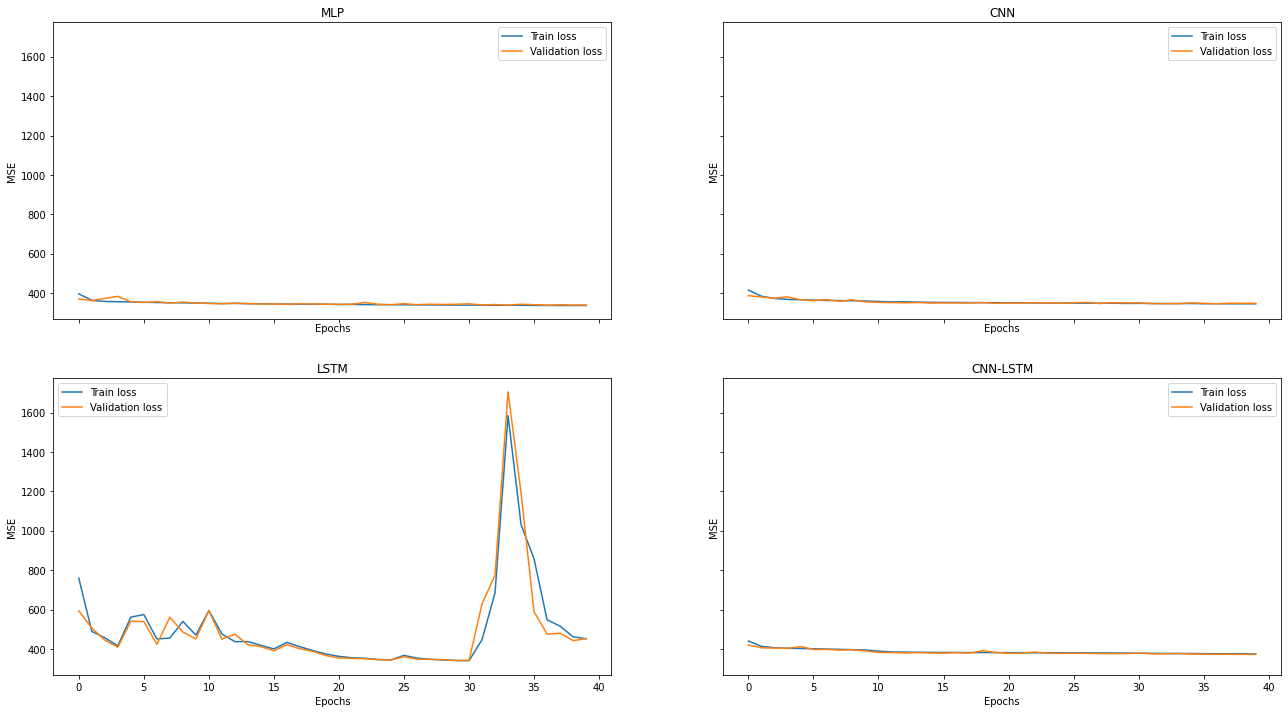

In [44]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

#### MLP on train and validation

In [4]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 29.345567962323305
Validation rmse: 29.324971409140172


#### CNN on train and validation

In [5]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 24.476234971323304
Validation rmse: 22.202471409140173


#### LSTM on train and validation

In [47]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

Train rmse: 21.307027302859716
Validation rmse: 18.66202570360532


#### CNN-LSTM on train and validation

In [2]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))


Train rmse: 19.345567962323305
Validation rmse: 19.324971409140172


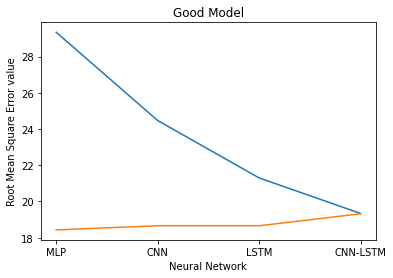

In [16]:
import matplotlib.pyplot as plt
plt.title("Good Model")
plt.xlabel("Neural Network")
plt.ylabel("Root Mean Square Error value")
plt.plot(['MLP','CNN','LSTM','CNN-LSTM'],[29.34,24.47,21.30,19.34])
plt.plot(['MLP','CNN','LSTM','CNN-LSTM'],[18.43,18.66,18.66,19.32])